In [1]:
# Install PyTorch
!pip install -U torch==1.8.1+cu101 torchvision==0.9.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html
# Install MMCV
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu101/torch1.8.0/index.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 763.7 MB 10 kB/s 
     |████████████████████████████████| 17.3 MB 72 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.8.1+cu101 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.8.1+cu101 which is incompatible.
Looking in links: https://download.openmmlab.com/mmcv/dist/cu101/torch1.8.0/index.

In [2]:
!rm -rf tcc
!git clone https://github.com/matheussn/tcc.git
%cd tcc

Cloning into 'tcc'...
remote: Enumerating objects: 393, done.
remote: Counting objects: 100% (393/393), done.
remote: Compressing objects: 100% (268/268), done.
remote: Total 393 (delta 183), reused 310 (delta 103), pack-reused 0
Receiving objects: 100% (393/393), 49.42 MiB | 12.74 MiB/s, done.
Resolving deltas: 100% (183/183), done.
/content/tcc


In [3]:
!rm -rf mmsegmentation
!git clone -b v0.20.2 https://github.com/open-mmlab/mmsegmentation.git 
%cd mmsegmentation
!pip install -e .

Cloning into 'mmsegmentation'...
remote: Enumerating objects: 6379, done.
remote: Counting objects: 100% (881/881), done.
remote: Compressing objects: 100% (491/491), done.
remote: Total 6379 (delta 525), reused 585 (delta 382), pack-reused 5498
Receiving objects: 100% (6379/6379), 13.21 MiB | 14.66 MiB/s, done.
Resolving deltas: 100% (4557/4557), done.
Note: checking out '991b0512b9f4835275957e4c4896b5f4c4696eac'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

/content/tcc/mmsegmentation
Obtaining file:///content/tcc/mmsegmentation
  Running setup.py develop for mmsegmentation


In [4]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
from mmseg.datasets import build_dataset
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset
from mmseg.apis import set_random_seed, train_segmentor
from mmseg.models import build_segmentor
print(mmseg.__version__)

import mmcv
from mmcv import Config

import os.path as osp
import numpy as np
from PIL import Image
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

1.8.1+cu101 True
0.20.2


In [5]:
!rm -rf ToTrain/
!unzip ../../ToTrain.zip

Archive:  ../../ToTrain.zip
   creating: ToTrain/
   creating: ToTrain/annotations/
  inflating: ToTrain/annotations/image020-roi1.tif  
  inflating: ToTrain/annotations/image008-roi1.tif  
  inflating: ToTrain/annotations/image032-roi1.tif  
  inflating: ToTrain/annotations/image019-roi2.tif  
  inflating: ToTrain/annotations/image019-roi5.tif  
  inflating: ToTrain/annotations/image058-roi5.tif  
  inflating: ToTrain/annotations/image038-roi4.tif  
  inflating: ToTrain/annotations/image058-roi1.tif  
  inflating: ToTrain/annotations/image021-roi3.tif  
  inflating: ToTrain/annotations/image006-roi2.tif  
  inflating: ToTrain/annotations/image021-roi6.tif  
  inflating: ToTrain/annotations/image038-roi1.tif  
  inflating: ToTrain/annotations/image003-2-roi3.tif  
  inflating: ToTrain/annotations/image038-roi3.tif  
  inflating: ToTrain/annotations/image039-roi3.tif  
  inflating: ToTrain/annotations/image017-roi1.tif  
  inflating: ToTrain/annotations/image004-roi2.tif  
  inflating: 

In [6]:
data_root = 'ToTrain'
img_dir = 'images'
ann_dir = 'annotations'

In [7]:
classes = ('bg', 'cell')
palette = [[0, 0, 0], [255, 255, 255]]

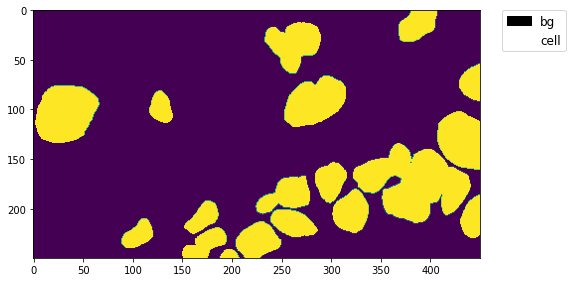

In [8]:
# Let's take a look at the segmentation map we got

img = Image.open('ToTrain/annotations/image003-2-roi1.tif')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img))

# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(2)]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()

In [9]:
# split train/val set randomly
split_dir = 'splits'
mmcv.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmcv.scandir(osp.join(data_root, ann_dir), suffix='.tif')]
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
    # select first 4/5 as train set
    train_length = int(len(filename_list)*4/5)
    f.writelines(line + '\n' for line in filename_list[:train_length])
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
    # select last 1/5 as train set
    f.writelines(line + '\n' for line in filename_list[train_length:])

In [10]:
@DATASETS.register_module()
class DysplasiaDataSet(CustomDataset):
    CLASSES = classes
    PALETTE = palette
    def __init__(self, split, **kwargs):
        super().__init__(img_suffix='.tif', seg_map_suffix='.tif', split=split, **kwargs)
        assert osp.exists(self.img_dir) and self.split is not None

In [11]:
cfg = Config.fromfile('../models/pspnet.py')

In [12]:
cfg.runner.max_epochs = 50
print(f'Config:\n{cfg.pretty_text}')

Config:
dataset_type = 'DysplasiaDataSet'
data_root = 'ToTrain'
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
crop_size = (256, 256)
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(320, 240), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=(256, 256), cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(
        type='Normalize',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        to_rgb=True),
    dict(type='Pad', size=(256, 256), pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg'])
]
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(256, 256),
        flip=False,
        transforms=[
            dict(type='Resize

In [13]:
datasets = [build_dataset(cfg.data.train)]

2022-03-05 12:42:40,101 - mmseg - INFO - Loaded 96 images


In [14]:
# Build the detector
model = build_segmentor(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

In [15]:
# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, meta=dict())

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
2022-03-05 12:42:49,476 - mmseg - INFO - Loaded 24 images
2022-03-05 12:42:49,482 - mmseg - INFO - Start running, host: root@8324bb4557dc, work_dir: /content/tcc/mmsegmentation/work_dirs/psp
2022-03-05 12:42:49,485 - mmseg - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch:
(VERY_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 9.8 task/s, elapsed: 2s, ETA:     0s

2022-03-05 12:43:09,650 - mmseg - INFO - per class results:
2022-03-05 12:43:09,654 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 80.68 | 100.0 |
|  cell |  0.0  |  0.0  |
+-------+-------+-------+
2022-03-05 12:43:09,657 - mmseg - INFO - Summary:
2022-03-05 12:43:09,662 - mmseg - INFO - 
+-------+-------+------+
|  aAcc | mDice | mAcc |
+-------+-------+------+
| 67.61 | 40.34 | 50.0 |
+-------+-------+------+
2022-03-05 12:43:09,667 - mmseg - INFO - Epoch(val) [1][24]	aAcc: 0.6761, mDice: 0.4034, mAcc: 0.5000, Dice.bg: 0.8068, Dice.cell: 0.0000, Acc.bg: 1.0000, Acc.cell: 0.0000
2022-03-05 12:43:26,993 - mmseg - INFO - Epoch [2][12/12]	lr: 9.822e-03, eta: 0:13:53, time: 1.433, data_time: 0.194, memory: 3768, decode.loss_ce: 0.5267, decode.acc_seg: 52.7488, aux.loss_ce: 0.2079, aux.acc_seg: 53.1193, loss: 0.7347


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.9 task/s, elapsed: 2s, ETA:     0s

2022-03-05 12:43:29,023 - mmseg - INFO - per class results:
2022-03-05 12:43:29,026 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 80.68 | 100.0 |
|  cell |  0.06 |  0.03 |
+-------+-------+-------+
2022-03-05 12:43:29,028 - mmseg - INFO - Summary:
2022-03-05 12:43:29,031 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 67.62 | 40.37 | 50.02 |
+-------+-------+-------+
2022-03-05 12:43:29,035 - mmseg - INFO - Epoch(val) [2][24]	aAcc: 0.6762, mDice: 0.4037, mAcc: 0.5002, Dice.bg: 0.8068, Dice.cell: 0.0006, Acc.bg: 1.0000, Acc.cell: 0.0003
2022-03-05 12:43:46,468 - mmseg - INFO - Epoch [3][12/12]	lr: 9.643e-03, eta: 0:13:35, time: 1.442, data_time: 0.191, memory: 3768, decode.loss_ce: 0.4747, decode.acc_seg: 50.8930, aux.loss_ce: 0.1898, aux.acc_seg: 50.9397, loss: 0.6645


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.8 task/s, elapsed: 2s, ETA:     0s

2022-03-05 12:43:48,516 - mmseg - INFO - per class results:
2022-03-05 12:43:48,520 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 79.44 | 92.18 |
|  cell | 25.14 | 16.73 |
+-------+-------+-------+
2022-03-05 12:43:48,521 - mmseg - INFO - Summary:
2022-03-05 12:43:48,524 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 67.74 | 52.29 | 54.45 |
+-------+-------+-------+
2022-03-05 12:43:48,535 - mmseg - INFO - Epoch(val) [3][24]	aAcc: 0.6774, mDice: 0.5229, mAcc: 0.5445, Dice.bg: 0.7944, Dice.cell: 0.2514, Acc.bg: 0.9218, Acc.cell: 0.1673
2022-03-05 12:44:06,030 - mmseg - INFO - Epoch [4][12/12]	lr: 9.464e-03, eta: 0:13:18, time: 1.447, data_time: 0.186, memory: 3768, decode.loss_ce: 0.4734, decode.acc_seg: 55.2035, aux.loss_ce: 0.1845, aux.acc_seg: 56.2125, loss: 0.6580


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 9.9 task/s, elapsed: 2s, ETA:     0s

2022-03-05 12:44:08,485 - mmseg - INFO - per class results:
2022-03-05 12:44:08,488 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 79.35 | 85.17 |
|  cell | 45.36 | 38.42 |
+-------+-------+-------+
2022-03-05 12:44:08,491 - mmseg - INFO - Summary:
2022-03-05 12:44:08,498 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 70.03 | 62.36 | 61.79 |
+-------+-------+-------+
2022-03-05 12:44:08,500 - mmseg - INFO - Epoch(val) [4][24]	aAcc: 0.7003, mDice: 0.6236, mAcc: 0.6179, Dice.bg: 0.7935, Dice.cell: 0.4536, Acc.bg: 0.8517, Acc.cell: 0.3842
2022-03-05 12:44:26,247 - mmseg - INFO - Epoch [5][12/12]	lr: 9.284e-03, eta: 0:13:03, time: 1.468, data_time: 0.195, memory: 3768, decode.loss_ce: 0.4289, decode.acc_seg: 57.4475, aux.loss_ce: 0.1742, aux.acc_seg: 57.0956, loss: 0.6032


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.5 task/s, elapsed: 2s, ETA:     0s

2022-03-05 12:44:28,335 - mmseg - INFO - per class results:
2022-03-05 12:44:28,337 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 81.67 | 89.47 |
|  cell | 47.64 | 38.15 |
+-------+-------+-------+
2022-03-05 12:44:28,342 - mmseg - INFO - Summary:
2022-03-05 12:44:28,345 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 72.85 | 64.66 | 63.81 |
+-------+-------+-------+
2022-03-05 12:44:28,347 - mmseg - INFO - Epoch(val) [5][24]	aAcc: 0.7285, mDice: 0.6466, mAcc: 0.6381, Dice.bg: 0.8167, Dice.cell: 0.4764, Acc.bg: 0.8947, Acc.cell: 0.3815
2022-03-05 12:44:46,140 - mmseg - INFO - Epoch [6][12/12]	lr: 9.104e-03, eta: 0:12:47, time: 1.471, data_time: 0.196, memory: 3768, decode.loss_ce: 0.4126, decode.acc_seg: 57.8806, aux.loss_ce: 0.1664, aux.acc_seg: 57.7736, loss: 0.5790


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 9.4 task/s, elapsed: 3s, ETA:     0s

2022-03-05 12:44:48,721 - mmseg - INFO - per class results:
2022-03-05 12:44:48,723 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 80.04 | 79.92 |
|  cell | 58.51 | 58.69 |
+-------+-------+-------+
2022-03-05 12:44:48,726 - mmseg - INFO - Summary:
2022-03-05 12:44:48,732 - mmseg - INFO - 
+-------+-------+------+
|  aAcc | mDice | mAcc |
+-------+-------+------+
| 73.04 | 69.27 | 69.3 |
+-------+-------+------+
2022-03-05 12:44:48,737 - mmseg - INFO - Epoch(val) [6][24]	aAcc: 0.7304, mDice: 0.6927, mAcc: 0.6930, Dice.bg: 0.8004, Dice.cell: 0.5851, Acc.bg: 0.7992, Acc.cell: 0.5869
2022-03-05 12:45:06,503 - mmseg - INFO - Epoch [7][12/12]	lr: 8.924e-03, eta: 0:12:31, time: 1.469, data_time: 0.194, memory: 3768, decode.loss_ce: 0.4191, decode.acc_seg: 62.0624, aux.loss_ce: 0.1706, aux.acc_seg: 61.7569, loss: 0.5897


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.3 task/s, elapsed: 2s, ETA:     0s

2022-03-05 12:45:08,636 - mmseg - INFO - per class results:
2022-03-05 12:45:08,638 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 83.79 |  88.8 |
|  cell | 59.02 | 51.65 |
+-------+-------+-------+
2022-03-05 12:45:08,644 - mmseg - INFO - Summary:
2022-03-05 12:45:08,646 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 76.77 |  71.4 | 70.23 |
+-------+-------+-------+
2022-03-05 12:45:08,649 - mmseg - INFO - Epoch(val) [7][24]	aAcc: 0.7677, mDice: 0.7140, mAcc: 0.7023, Dice.bg: 0.8379, Dice.cell: 0.5902, Acc.bg: 0.8880, Acc.cell: 0.5165
2022-03-05 12:45:26,392 - mmseg - INFO - Epoch [8][12/12]	lr: 8.743e-03, eta: 0:12:14, time: 1.467, data_time: 0.191, memory: 3768, decode.loss_ce: 0.3682, decode.acc_seg: 57.0173, aux.loss_ce: 0.1529, aux.acc_seg: 55.8794, loss: 0.5211


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.1 task/s, elapsed: 2s, ETA:     0s

2022-03-05 12:45:28,793 - mmseg - INFO - per class results:
2022-03-05 12:45:28,795 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 83.81 | 86.17 |
|  cell | 63.08 | 59.38 |
+-------+-------+-------+
2022-03-05 12:45:28,798 - mmseg - INFO - Summary:
2022-03-05 12:45:28,802 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 77.49 | 73.45 | 72.77 |
+-------+-------+-------+
2022-03-05 12:45:28,803 - mmseg - INFO - Epoch(val) [8][24]	aAcc: 0.7749, mDice: 0.7345, mAcc: 0.7277, Dice.bg: 0.8381, Dice.cell: 0.6308, Acc.bg: 0.8617, Acc.cell: 0.5938
2022-03-05 12:45:46,471 - mmseg - INFO - Epoch [9][12/12]	lr: 8.562e-03, eta: 0:11:57, time: 1.461, data_time: 0.185, memory: 3768, decode.loss_ce: 0.3955, decode.acc_seg: 60.3980, aux.loss_ce: 0.1587, aux.acc_seg: 59.9829, loss: 0.5543


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.4 task/s, elapsed: 2s, ETA:     0s

2022-03-05 12:45:48,577 - mmseg - INFO - per class results:
2022-03-05 12:45:48,579 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 82.49 | 80.69 |
|  cell |  65.8 |  68.8 |
+-------+-------+-------+
2022-03-05 12:45:48,582 - mmseg - INFO - Summary:
2022-03-05 12:45:48,588 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 76.84 | 74.14 | 74.74 |
+-------+-------+-------+
2022-03-05 12:45:48,590 - mmseg - INFO - Epoch(val) [9][24]	aAcc: 0.7684, mDice: 0.7414, mAcc: 0.7474, Dice.bg: 0.8249, Dice.cell: 0.6580, Acc.bg: 0.8069, Acc.cell: 0.6880
2022-03-05 12:46:06,411 - mmseg - INFO - Epoch [10][12/12]	lr: 8.381e-03, eta: 0:11:40, time: 1.474, data_time: 0.195, memory: 3768, decode.loss_ce: 0.3303, decode.acc_seg: 54.6411, aux.loss_ce: 0.1338, aux.acc_seg: 54.2764, loss: 0.4642
2022-03-05 12:46:06,414 - mmseg - INFO - Saving checkpoint at 10 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 10.9 task/s, elapsed: 2s, ETA:     0s

2022-03-05 12:46:11,134 - mmseg - INFO - per class results:
2022-03-05 12:46:11,136 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 83.47 | 83.26 |
|  cell | 65.75 | 66.09 |
+-------+-------+-------+
2022-03-05 12:46:11,138 - mmseg - INFO - Summary:
2022-03-05 12:46:11,141 - mmseg - INFO - 
+------+-------+-------+
| aAcc | mDice |  mAcc |
+------+-------+-------+
| 77.7 | 74.61 | 74.67 |
+------+-------+-------+
2022-03-05 12:46:11,145 - mmseg - INFO - Epoch(val) [10][24]	aAcc: 0.7770, mDice: 0.7461, mAcc: 0.7467, Dice.bg: 0.8347, Dice.cell: 0.6575, Acc.bg: 0.8326, Acc.cell: 0.6609
2022-03-05 12:46:28,928 - mmseg - INFO - Epoch [11][12/12]	lr: 8.199e-03, eta: 0:11:23, time: 1.471, data_time: 0.191, memory: 3768, decode.loss_ce: 0.4004, decode.acc_seg: 60.7912, aux.loss_ce: 0.1600, aux.acc_seg: 60.8011, loss: 0.5604


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.5 task/s, elapsed: 2s, ETA:     0s

2022-03-05 12:46:31,033 - mmseg - INFO - per class results:
2022-03-05 12:46:31,037 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.79 | 92.91 |
|  cell | 56.53 | 45.23 |
+-------+-------+-------+
2022-03-05 12:46:31,038 - mmseg - INFO - Summary:
2022-03-05 12:46:31,041 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 77.47 | 70.66 | 69.07 |
+-------+-------+-------+
2022-03-05 12:46:31,046 - mmseg - INFO - Epoch(val) [11][24]	aAcc: 0.7747, mDice: 0.7066, mAcc: 0.6907, Dice.bg: 0.8479, Dice.cell: 0.5653, Acc.bg: 0.9291, Acc.cell: 0.4523
2022-03-05 12:46:48,812 - mmseg - INFO - Epoch [12][12/12]	lr: 8.016e-03, eta: 0:11:06, time: 1.469, data_time: 0.189, memory: 3768, decode.loss_ce: 0.3941, decode.acc_seg: 60.8324, aux.loss_ce: 0.1550, aux.acc_seg: 60.9035, loss: 0.5491


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.4 task/s, elapsed: 2s, ETA:     0s

2022-03-05 12:46:50,932 - mmseg - INFO - per class results:
2022-03-05 12:46:50,933 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.02 | 88.79 |
|  cell | 64.01 | 58.09 |
+-------+-------+-------+
2022-03-05 12:46:50,937 - mmseg - INFO - Summary:
2022-03-05 12:46:50,939 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 78.85 | 74.52 | 73.44 |
+-------+-------+-------+
2022-03-05 12:46:50,941 - mmseg - INFO - Epoch(val) [12][24]	aAcc: 0.7885, mDice: 0.7452, mAcc: 0.7344, Dice.bg: 0.8502, Dice.cell: 0.6401, Acc.bg: 0.8879, Acc.cell: 0.5809
2022-03-05 12:47:08,602 - mmseg - INFO - Epoch [13][12/12]	lr: 7.833e-03, eta: 0:10:48, time: 1.461, data_time: 0.183, memory: 3768, decode.loss_ce: 0.3640, decode.acc_seg: 61.1576, aux.loss_ce: 0.1458, aux.acc_seg: 60.9434, loss: 0.5098


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 9.3 task/s, elapsed: 3s, ETA:     0s

2022-03-05 12:47:11,204 - mmseg - INFO - per class results:
2022-03-05 12:47:11,207 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.86 | 87.83 |
|  cell | 64.71 | 59.98 |
+-------+-------+-------+
2022-03-05 12:47:11,214 - mmseg - INFO - Summary:
2022-03-05 12:47:11,217 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 78.81 | 74.78 | 73.91 |
+-------+-------+-------+
2022-03-05 12:47:11,218 - mmseg - INFO - Epoch(val) [13][24]	aAcc: 0.7881, mDice: 0.7478, mAcc: 0.7391, Dice.bg: 0.8486, Dice.cell: 0.6471, Acc.bg: 0.8783, Acc.cell: 0.5998
2022-03-05 12:47:28,968 - mmseg - INFO - Epoch [14][12/12]	lr: 7.650e-03, eta: 0:10:31, time: 1.468, data_time: 0.189, memory: 3768, decode.loss_ce: 0.3633, decode.acc_seg: 62.8138, aux.loss_ce: 0.1477, aux.acc_seg: 62.4104, loss: 0.5110


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.2 task/s, elapsed: 2s, ETA:     0s

2022-03-05 12:47:31,112 - mmseg - INFO - per class results:
2022-03-05 12:47:31,115 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 82.84 | 80.57 |
|  cell | 67.05 | 70.89 |
+-------+-------+-------+
2022-03-05 12:47:31,117 - mmseg - INFO - Summary:
2022-03-05 12:47:31,123 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 77.44 | 74.95 | 75.73 |
+-------+-------+-------+
2022-03-05 12:47:31,126 - mmseg - INFO - Epoch(val) [14][24]	aAcc: 0.7744, mDice: 0.7495, mAcc: 0.7573, Dice.bg: 0.8284, Dice.cell: 0.6705, Acc.bg: 0.8057, Acc.cell: 0.7089
2022-03-05 12:47:48,825 - mmseg - INFO - Epoch [15][12/12]	lr: 7.466e-03, eta: 0:10:13, time: 1.464, data_time: 0.187, memory: 3768, decode.loss_ce: 0.3405, decode.acc_seg: 57.9701, aux.loss_ce: 0.1392, aux.acc_seg: 57.6217, loss: 0.4797


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.2 task/s, elapsed: 2s, ETA:     0s

2022-03-05 12:47:50,978 - mmseg - INFO - per class results:
2022-03-05 12:47:50,981 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.71 | 84.73 |
|  cell | 68.06 | 68.02 |
+-------+-------+-------+
2022-03-05 12:47:50,985 - mmseg - INFO - Summary:
2022-03-05 12:47:50,989 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 79.32 | 76.38 | 76.38 |
+-------+-------+-------+
2022-03-05 12:47:50,993 - mmseg - INFO - Epoch(val) [15][24]	aAcc: 0.7932, mDice: 0.7638, mAcc: 0.7638, Dice.bg: 0.8471, Dice.cell: 0.6806, Acc.bg: 0.8473, Acc.cell: 0.6802
2022-03-05 12:48:08,730 - mmseg - INFO - Epoch [16][12/12]	lr: 7.282e-03, eta: 0:09:56, time: 1.467, data_time: 0.188, memory: 3768, decode.loss_ce: 0.3495, decode.acc_seg: 60.9228, aux.loss_ce: 0.1425, aux.acc_seg: 60.5467, loss: 0.4920


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.5 task/s, elapsed: 2s, ETA:     0s

2022-03-05 12:48:10,829 - mmseg - INFO - per class results:
2022-03-05 12:48:10,833 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.61 | 83.85 |
|  cell | 68.77 | 70.07 |
+-------+-------+-------+
2022-03-05 12:48:10,834 - mmseg - INFO - Summary:
2022-03-05 12:48:10,836 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 79.38 | 76.69 | 76.96 |
+-------+-------+-------+
2022-03-05 12:48:10,838 - mmseg - INFO - Epoch(val) [16][24]	aAcc: 0.7938, mDice: 0.7669, mAcc: 0.7696, Dice.bg: 0.8461, Dice.cell: 0.6877, Acc.bg: 0.8385, Acc.cell: 0.7007
2022-03-05 12:48:28,540 - mmseg - INFO - Epoch [17][12/12]	lr: 7.097e-03, eta: 0:09:39, time: 1.464, data_time: 0.183, memory: 3768, decode.loss_ce: 0.3766, decode.acc_seg: 63.7275, aux.loss_ce: 0.1532, aux.acc_seg: 63.3623, loss: 0.5297


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.5 task/s, elapsed: 2s, ETA:     0s

2022-03-05 12:48:30,635 - mmseg - INFO - per class results:
2022-03-05 12:48:30,637 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 82.18 | 77.05 |
|  cell | 69.15 | 78.16 |
+-------+-------+-------+
2022-03-05 12:48:30,642 - mmseg - INFO - Summary:
2022-03-05 12:48:30,645 - mmseg - INFO - 
+-------+-------+------+
|  aAcc | mDice | mAcc |
+-------+-------+------+
| 77.41 | 75.66 | 77.6 |
+-------+-------+------+
2022-03-05 12:48:30,653 - mmseg - INFO - Epoch(val) [17][24]	aAcc: 0.7741, mDice: 0.7566, mAcc: 0.7760, Dice.bg: 0.8218, Dice.cell: 0.6915, Acc.bg: 0.7705, Acc.cell: 0.7816
2022-03-05 12:48:48,377 - mmseg - INFO - Epoch [18][12/12]	lr: 6.911e-03, eta: 0:09:21, time: 1.466, data_time: 0.186, memory: 3768, decode.loss_ce: 0.3467, decode.acc_seg: 60.8639, aux.loss_ce: 0.1407, aux.acc_seg: 60.5378, loss: 0.4873


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.4 task/s, elapsed: 2s, ETA:     0s

2022-03-05 12:48:50,496 - mmseg - INFO - per class results:
2022-03-05 12:48:50,498 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 82.86 | 78.62 |
|  cell | 69.32 | 76.73 |
+-------+-------+-------+
2022-03-05 12:48:50,501 - mmseg - INFO - Summary:
2022-03-05 12:48:50,509 - mmseg - INFO - 
+------+-------+-------+
| aAcc | mDice |  mAcc |
+------+-------+-------+
| 78.0 | 76.09 | 77.67 |
+------+-------+-------+
2022-03-05 12:48:50,510 - mmseg - INFO - Epoch(val) [18][24]	aAcc: 0.7800, mDice: 0.7609, mAcc: 0.7767, Dice.bg: 0.8286, Dice.cell: 0.6932, Acc.bg: 0.7862, Acc.cell: 0.7673
2022-03-05 12:49:08,292 - mmseg - INFO - Epoch [19][12/12]	lr: 6.725e-03, eta: 0:09:04, time: 1.471, data_time: 0.191, memory: 3768, decode.loss_ce: 0.3350, decode.acc_seg: 61.1819, aux.loss_ce: 0.1363, aux.acc_seg: 60.7905, loss: 0.4713


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.4 task/s, elapsed: 2s, ETA:     0s

2022-03-05 12:49:10,412 - mmseg - INFO - per class results:
2022-03-05 12:49:10,414 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.87 | 83.98 |
|  cell | 69.44 | 70.97 |
+-------+-------+-------+
2022-03-05 12:49:10,415 - mmseg - INFO - Summary:
2022-03-05 12:49:10,419 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 79.76 | 77.16 | 77.47 |
+-------+-------+-------+
2022-03-05 12:49:10,420 - mmseg - INFO - Epoch(val) [19][24]	aAcc: 0.7976, mDice: 0.7716, mAcc: 0.7747, Dice.bg: 0.8487, Dice.cell: 0.6944, Acc.bg: 0.8398, Acc.cell: 0.7097
2022-03-05 12:49:28,187 - mmseg - INFO - Epoch [20][12/12]	lr: 6.539e-03, eta: 0:08:46, time: 1.469, data_time: 0.190, memory: 3768, decode.loss_ce: 0.3301, decode.acc_seg: 62.8500, aux.loss_ce: 0.1353, aux.acc_seg: 62.3578, loss: 0.4654
2022-03-05 12:49:28,190 - mmseg - INFO - Saving checkpoint at 20 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.3 task/s, elapsed: 2s, ETA:     0s

2022-03-05 12:49:32,207 - mmseg - INFO - per class results:
2022-03-05 12:49:32,208 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.86 | 83.68 |
|  cell | 69.71 | 71.72 |
+-------+-------+-------+
2022-03-05 12:49:32,211 - mmseg - INFO - Summary:
2022-03-05 12:49:32,216 - mmseg - INFO - 
+-------+-------+------+
|  aAcc | mDice | mAcc |
+-------+-------+------+
| 79.81 | 77.28 | 77.7 |
+-------+-------+------+
2022-03-05 12:49:32,219 - mmseg - INFO - Epoch(val) [20][24]	aAcc: 0.7981, mDice: 0.7728, mAcc: 0.7770, Dice.bg: 0.8486, Dice.cell: 0.6971, Acc.bg: 0.8368, Acc.cell: 0.7172
2022-03-05 12:49:50,026 - mmseg - INFO - Epoch [21][12/12]	lr: 6.351e-03, eta: 0:08:29, time: 1.472, data_time: 0.189, memory: 3768, decode.loss_ce: 0.3310, decode.acc_seg: 60.3976, aux.loss_ce: 0.1384, aux.acc_seg: 59.5458, loss: 0.4694


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.4 task/s, elapsed: 2s, ETA:     0s

2022-03-05 12:49:52,132 - mmseg - INFO - per class results:
2022-03-05 12:49:52,134 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 83.15 | 78.82 |
|  cell | 69.93 | 77.54 |
+-------+-------+-------+
2022-03-05 12:49:52,136 - mmseg - INFO - Summary:
2022-03-05 12:49:52,139 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 78.41 | 76.54 | 78.18 |
+-------+-------+-------+
2022-03-05 12:49:52,140 - mmseg - INFO - Epoch(val) [21][24]	aAcc: 0.7841, mDice: 0.7654, mAcc: 0.7818, Dice.bg: 0.8315, Dice.cell: 0.6993, Acc.bg: 0.7882, Acc.cell: 0.7754
2022-03-05 12:50:09,959 - mmseg - INFO - Epoch [22][12/12]	lr: 6.163e-03, eta: 0:08:11, time: 1.473, data_time: 0.190, memory: 3768, decode.loss_ce: 0.3425, decode.acc_seg: 65.4740, aux.loss_ce: 0.1394, aux.acc_seg: 65.2009, loss: 0.4819


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.5 task/s, elapsed: 2s, ETA:     0s

2022-03-05 12:50:12,063 - mmseg - INFO - per class results:
2022-03-05 12:50:12,067 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.83 | 82.76 |
|  cell |  70.6 | 74.21 |
+-------+-------+-------+
2022-03-05 12:50:12,069 - mmseg - INFO - Summary:
2022-03-05 12:50:12,077 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 79.99 | 77.72 | 78.48 |
+-------+-------+-------+
2022-03-05 12:50:12,080 - mmseg - INFO - Epoch(val) [22][24]	aAcc: 0.7999, mDice: 0.7772, mAcc: 0.7848, Dice.bg: 0.8483, Dice.cell: 0.7060, Acc.bg: 0.8276, Acc.cell: 0.7421
2022-03-05 12:50:29,816 - mmseg - INFO - Epoch [23][12/12]	lr: 5.975e-03, eta: 0:07:54, time: 1.467, data_time: 0.189, memory: 3768, decode.loss_ce: 0.3340, decode.acc_seg: 62.2770, aux.loss_ce: 0.1360, aux.acc_seg: 61.9174, loss: 0.4700


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.4 task/s, elapsed: 2s, ETA:     0s

2022-03-05 12:50:31,928 - mmseg - INFO - per class results:
2022-03-05 12:50:31,929 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.94 | 82.97 |
|  cell |  70.7 | 74.12 |
+-------+-------+-------+
2022-03-05 12:50:31,932 - mmseg - INFO - Summary:
2022-03-05 12:50:31,942 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.11 | 77.82 | 78.55 |
+-------+-------+-------+
2022-03-05 12:50:31,946 - mmseg - INFO - Epoch(val) [23][24]	aAcc: 0.8011, mDice: 0.7782, mAcc: 0.7855, Dice.bg: 0.8494, Dice.cell: 0.7070, Acc.bg: 0.8297, Acc.cell: 0.7412
2022-03-05 12:50:49,771 - mmseg - INFO - Epoch [24][12/12]	lr: 5.786e-03, eta: 0:07:36, time: 1.474, data_time: 0.194, memory: 3768, decode.loss_ce: 0.3281, decode.acc_seg: 64.3454, aux.loss_ce: 0.1349, aux.acc_seg: 63.8414, loss: 0.4629


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.5 task/s, elapsed: 2s, ETA:     0s

2022-03-05 12:50:51,870 - mmseg - INFO - per class results:
2022-03-05 12:50:51,871 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.44 | 81.87 |
|  cell | 70.38 | 74.85 |
+-------+-------+-------+
2022-03-05 12:50:51,877 - mmseg - INFO - Summary:
2022-03-05 12:50:51,881 - mmseg - INFO - 
+------+-------+-------+
| aAcc | mDice |  mAcc |
+------+-------+-------+
| 79.6 | 77.41 | 78.36 |
+------+-------+-------+
2022-03-05 12:50:51,889 - mmseg - INFO - Epoch(val) [24][24]	aAcc: 0.7960, mDice: 0.7741, mAcc: 0.7836, Dice.bg: 0.8444, Dice.cell: 0.7038, Acc.bg: 0.8187, Acc.cell: 0.7485
2022-03-05 12:51:09,650 - mmseg - INFO - Epoch [25][12/12]	lr: 5.596e-03, eta: 0:07:19, time: 1.469, data_time: 0.189, memory: 3768, decode.loss_ce: 0.3411, decode.acc_seg: 63.2277, aux.loss_ce: 0.1389, aux.acc_seg: 62.7582, loss: 0.4801


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.4 task/s, elapsed: 2s, ETA:     0s

2022-03-05 12:51:11,774 - mmseg - INFO - per class results:
2022-03-05 12:51:11,777 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.24 | 84.41 |
|  cell | 70.09 | 71.51 |
+-------+-------+-------+
2022-03-05 12:51:11,779 - mmseg - INFO - Summary:
2022-03-05 12:51:11,785 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.23 | 77.66 | 77.96 |
+-------+-------+-------+
2022-03-05 12:51:11,788 - mmseg - INFO - Epoch(val) [25][24]	aAcc: 0.8023, mDice: 0.7766, mAcc: 0.7796, Dice.bg: 0.8524, Dice.cell: 0.7009, Acc.bg: 0.8441, Acc.cell: 0.7151
2022-03-05 12:51:29,546 - mmseg - INFO - Epoch [26][12/12]	lr: 5.405e-03, eta: 0:07:01, time: 1.468, data_time: 0.187, memory: 3768, decode.loss_ce: 0.3388, decode.acc_seg: 63.9405, aux.loss_ce: 0.1407, aux.acc_seg: 63.2404, loss: 0.4795


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.5 task/s, elapsed: 2s, ETA:     0s

2022-03-05 12:51:31,654 - mmseg - INFO - per class results:
2022-03-05 12:51:31,656 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.17 | 83.87 |
|  cell | 70.47 | 72.73 |
+-------+-------+-------+
2022-03-05 12:51:31,661 - mmseg - INFO - Summary:
2022-03-05 12:51:31,667 - mmseg - INFO - 
+-------+-------+------+
|  aAcc | mDice | mAcc |
+-------+-------+------+
| 80.26 | 77.82 | 78.3 |
+-------+-------+------+
2022-03-05 12:51:31,674 - mmseg - INFO - Epoch(val) [26][24]	aAcc: 0.8026, mDice: 0.7782, mAcc: 0.7830, Dice.bg: 0.8517, Dice.cell: 0.7047, Acc.bg: 0.8387, Acc.cell: 0.7273
2022-03-05 12:51:49,324 - mmseg - INFO - Epoch [27][12/12]	lr: 5.214e-03, eta: 0:06:44, time: 1.460, data_time: 0.180, memory: 3768, decode.loss_ce: 0.3216, decode.acc_seg: 61.2861, aux.loss_ce: 0.1330, aux.acc_seg: 60.5872, loss: 0.4546


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.4 task/s, elapsed: 2s, ETA:     0s

2022-03-05 12:51:51,436 - mmseg - INFO - per class results:
2022-03-05 12:51:51,439 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.59 | 84.81 |
|  cell | 70.74 | 72.09 |
+-------+-------+-------+
2022-03-05 12:51:51,441 - mmseg - INFO - Summary:
2022-03-05 12:51:51,446 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.69 | 78.16 | 78.45 |
+-------+-------+-------+
2022-03-05 12:51:51,449 - mmseg - INFO - Epoch(val) [27][24]	aAcc: 0.8069, mDice: 0.7816, mAcc: 0.7845, Dice.bg: 0.8559, Dice.cell: 0.7074, Acc.bg: 0.8481, Acc.cell: 0.7209
2022-03-05 12:52:09,209 - mmseg - INFO - Epoch [28][12/12]	lr: 5.022e-03, eta: 0:06:26, time: 1.469, data_time: 0.191, memory: 3768, decode.loss_ce: 0.3429, decode.acc_seg: 64.8652, aux.loss_ce: 0.1395, aux.acc_seg: 64.4034, loss: 0.4823


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.5 task/s, elapsed: 2s, ETA:     0s

2022-03-05 12:52:11,314 - mmseg - INFO - per class results:
2022-03-05 12:52:11,316 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 82.47 | 76.51 |
|  cell | 70.49 | 81.13 |
+-------+-------+-------+
2022-03-05 12:52:11,317 - mmseg - INFO - Summary:
2022-03-05 12:52:11,321 - mmseg - INFO - 
+------+-------+-------+
| aAcc | mDice |  mAcc |
+------+-------+-------+
| 78.0 | 76.48 | 78.82 |
+------+-------+-------+
2022-03-05 12:52:11,330 - mmseg - INFO - Epoch(val) [28][24]	aAcc: 0.7800, mDice: 0.7648, mAcc: 0.7882, Dice.bg: 0.8247, Dice.cell: 0.7049, Acc.bg: 0.7651, Acc.cell: 0.8113
2022-03-05 12:52:29,066 - mmseg - INFO - Epoch [29][12/12]	lr: 4.829e-03, eta: 0:06:09, time: 1.467, data_time: 0.189, memory: 3768, decode.loss_ce: 0.3357, decode.acc_seg: 66.9471, aux.loss_ce: 0.1366, aux.acc_seg: 66.6214, loss: 0.4723


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.4 task/s, elapsed: 2s, ETA:     0s

2022-03-05 12:52:31,185 - mmseg - INFO - per class results:
2022-03-05 12:52:31,189 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.71 | 84.78 |
|  cell | 71.14 | 72.75 |
+-------+-------+-------+
2022-03-05 12:52:31,191 - mmseg - INFO - Summary:
2022-03-05 12:52:31,193 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.88 | 78.42 | 78.76 |
+-------+-------+-------+
2022-03-05 12:52:31,204 - mmseg - INFO - Epoch(val) [29][24]	aAcc: 0.8088, mDice: 0.7842, mAcc: 0.7876, Dice.bg: 0.8571, Dice.cell: 0.7114, Acc.bg: 0.8478, Acc.cell: 0.7275
2022-03-05 12:52:48,915 - mmseg - INFO - Epoch [30][12/12]	lr: 4.635e-03, eta: 0:05:51, time: 1.465, data_time: 0.186, memory: 3768, decode.loss_ce: 0.3342, decode.acc_seg: 66.2951, aux.loss_ce: 0.1376, aux.acc_seg: 65.6034, loss: 0.4718
2022-03-05 12:52:48,917 - mmseg - INFO - Saving checkpoint at 30 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.2 task/s, elapsed: 2s, ETA:     0s

2022-03-05 12:52:52,750 - mmseg - INFO - per class results:
2022-03-05 12:52:52,753 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.27 | 80.39 |
|  cell | 71.43 |  78.3 |
+-------+-------+-------+
2022-03-05 12:52:52,757 - mmseg - INFO - Summary:
2022-03-05 12:52:52,764 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 79.72 | 77.85 | 79.35 |
+-------+-------+-------+
2022-03-05 12:52:52,766 - mmseg - INFO - Epoch(val) [30][24]	aAcc: 0.7972, mDice: 0.7785, mAcc: 0.7935, Dice.bg: 0.8427, Dice.cell: 0.7143, Acc.bg: 0.8039, Acc.cell: 0.7830
2022-03-05 12:53:10,496 - mmseg - INFO - Epoch [31][12/12]	lr: 4.440e-03, eta: 0:05:34, time: 1.466, data_time: 0.185, memory: 3768, decode.loss_ce: 0.3241, decode.acc_seg: 64.0251, aux.loss_ce: 0.1322, aux.acc_seg: 63.6346, loss: 0.4563


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.3 task/s, elapsed: 2s, ETA:     0s

2022-03-05 12:53:12,622 - mmseg - INFO - per class results:
2022-03-05 12:53:12,627 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  |  85.6 | 83.81 |
|  cell | 71.81 | 74.95 |
+-------+-------+-------+
2022-03-05 12:53:12,629 - mmseg - INFO - Summary:
2022-03-05 12:53:12,631 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.94 | 78.71 | 79.38 |
+-------+-------+-------+
2022-03-05 12:53:12,633 - mmseg - INFO - Epoch(val) [31][24]	aAcc: 0.8094, mDice: 0.7871, mAcc: 0.7938, Dice.bg: 0.8560, Dice.cell: 0.7181, Acc.bg: 0.8381, Acc.cell: 0.7495
2022-03-05 12:53:30,324 - mmseg - INFO - Epoch [32][12/12]	lr: 4.244e-03, eta: 0:05:16, time: 1.462, data_time: 0.185, memory: 3768, decode.loss_ce: 0.3239, decode.acc_seg: 64.5122, aux.loss_ce: 0.1353, aux.acc_seg: 63.7351, loss: 0.4592


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.4 task/s, elapsed: 2s, ETA:     0s

2022-03-05 12:53:32,435 - mmseg - INFO - per class results:
2022-03-05 12:53:32,439 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  |  86.1 | 85.58 |
|  cell | 71.51 | 72.41 |
+-------+-------+-------+
2022-03-05 12:53:32,441 - mmseg - INFO - Summary:
2022-03-05 12:53:32,442 - mmseg - INFO - 
+-------+-------+------+
|  aAcc | mDice | mAcc |
+-------+-------+------+
| 81.32 | 78.81 | 79.0 |
+-------+-------+------+
2022-03-05 12:53:32,445 - mmseg - INFO - Epoch(val) [32][24]	aAcc: 0.8132, mDice: 0.7881, mAcc: 0.7900, Dice.bg: 0.8610, Dice.cell: 0.7151, Acc.bg: 0.8558, Acc.cell: 0.7241
2022-03-05 12:53:50,172 - mmseg - INFO - Epoch [33][12/12]	lr: 4.047e-03, eta: 0:04:58, time: 1.465, data_time: 0.185, memory: 3768, decode.loss_ce: 0.3285, decode.acc_seg: 66.7435, aux.loss_ce: 0.1357, aux.acc_seg: 66.2112, loss: 0.4642


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.5 task/s, elapsed: 2s, ETA:     0s

2022-03-05 12:53:52,265 - mmseg - INFO - per class results:
2022-03-05 12:53:52,268 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 83.58 | 78.33 |
|  cell |  71.6 | 80.98 |
+-------+-------+-------+
2022-03-05 12:53:52,271 - mmseg - INFO - Summary:
2022-03-05 12:53:52,280 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 79.19 | 77.59 | 79.66 |
+-------+-------+-------+
2022-03-05 12:53:52,281 - mmseg - INFO - Epoch(val) [33][24]	aAcc: 0.7919, mDice: 0.7759, mAcc: 0.7966, Dice.bg: 0.8358, Dice.cell: 0.7160, Acc.bg: 0.7833, Acc.cell: 0.8098
2022-03-05 12:54:10,034 - mmseg - INFO - Epoch [34][12/12]	lr: 3.849e-03, eta: 0:04:41, time: 1.468, data_time: 0.187, memory: 3768, decode.loss_ce: 0.3173, decode.acc_seg: 62.5046, aux.loss_ce: 0.1291, aux.acc_seg: 62.1528, loss: 0.4464


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.4 task/s, elapsed: 2s, ETA:     0s

2022-03-05 12:54:12,143 - mmseg - INFO - per class results:
2022-03-05 12:54:12,149 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.78 | 84.15 |
|  cell | 71.98 | 74.83 |
+-------+-------+-------+
2022-03-05 12:54:12,150 - mmseg - INFO - Summary:
2022-03-05 12:54:12,152 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 81.13 | 78.88 | 79.49 |
+-------+-------+-------+
2022-03-05 12:54:12,158 - mmseg - INFO - Epoch(val) [34][24]	aAcc: 0.8113, mDice: 0.7888, mAcc: 0.7949, Dice.bg: 0.8578, Dice.cell: 0.7198, Acc.bg: 0.8415, Acc.cell: 0.7483
2022-03-05 12:54:29,867 - mmseg - INFO - Epoch [35][12/12]	lr: 3.650e-03, eta: 0:04:23, time: 1.464, data_time: 0.187, memory: 3768, decode.loss_ce: 0.3249, decode.acc_seg: 65.0850, aux.loss_ce: 0.1324, aux.acc_seg: 64.7274, loss: 0.4573


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.5 task/s, elapsed: 2s, ETA:     0s

2022-03-05 12:54:31,956 - mmseg - INFO - per class results:
2022-03-05 12:54:31,959 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.88 | 81.28 |
|  cell | 72.23 | 78.62 |
+-------+-------+-------+
2022-03-05 12:54:31,962 - mmseg - INFO - Summary:
2022-03-05 12:54:31,969 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.42 | 78.55 | 79.95 |
+-------+-------+-------+
2022-03-05 12:54:31,974 - mmseg - INFO - Epoch(val) [35][24]	aAcc: 0.8042, mDice: 0.7855, mAcc: 0.7995, Dice.bg: 0.8488, Dice.cell: 0.7223, Acc.bg: 0.8128, Acc.cell: 0.7862
2022-03-05 12:54:49,705 - mmseg - INFO - Epoch [36][12/12]	lr: 3.450e-03, eta: 0:04:06, time: 1.467, data_time: 0.188, memory: 3768, decode.loss_ce: 0.3212, decode.acc_seg: 64.1778, aux.loss_ce: 0.1324, aux.acc_seg: 63.6401, loss: 0.4536


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.5 task/s, elapsed: 2s, ETA:     0s

2022-03-05 12:54:51,801 - mmseg - INFO - per class results:
2022-03-05 12:54:51,804 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  |  85.0 | 81.42 |
|  cell | 72.42 | 78.77 |
+-------+-------+-------+
2022-03-05 12:54:51,807 - mmseg - INFO - Summary:
2022-03-05 12:54:51,816 - mmseg - INFO - 
+-------+-------+------+
|  aAcc | mDice | mAcc |
+-------+-------+------+
| 80.56 | 78.71 | 80.1 |
+-------+-------+------+
2022-03-05 12:54:51,817 - mmseg - INFO - Epoch(val) [36][24]	aAcc: 0.8056, mDice: 0.7871, mAcc: 0.8010, Dice.bg: 0.8500, Dice.cell: 0.7242, Acc.bg: 0.8142, Acc.cell: 0.7877
2022-03-05 12:55:09,560 - mmseg - INFO - Epoch [37][12/12]	lr: 3.248e-03, eta: 0:03:48, time: 1.467, data_time: 0.187, memory: 3768, decode.loss_ce: 0.3269, decode.acc_seg: 64.8822, aux.loss_ce: 0.1356, aux.acc_seg: 64.2310, loss: 0.4625


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.5 task/s, elapsed: 2s, ETA:     0s

2022-03-05 12:55:11,658 - mmseg - INFO - per class results:
2022-03-05 12:55:11,662 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.76 |  80.9 |
|  cell | 72.27 | 79.14 |
+-------+-------+-------+
2022-03-05 12:55:11,669 - mmseg - INFO - Summary:
2022-03-05 12:55:11,671 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.33 | 78.52 | 80.02 |
+-------+-------+-------+
2022-03-05 12:55:11,673 - mmseg - INFO - Epoch(val) [37][24]	aAcc: 0.8033, mDice: 0.7852, mAcc: 0.8002, Dice.bg: 0.8476, Dice.cell: 0.7227, Acc.bg: 0.8090, Acc.cell: 0.7914
2022-03-05 12:55:29,406 - mmseg - INFO - Epoch [38][12/12]	lr: 3.045e-03, eta: 0:03:30, time: 1.467, data_time: 0.190, memory: 3768, decode.loss_ce: 0.3051, decode.acc_seg: 63.2930, aux.loss_ce: 0.1259, aux.acc_seg: 62.7833, loss: 0.4310


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.5 task/s, elapsed: 2s, ETA:     0s

2022-03-05 12:55:31,512 - mmseg - INFO - per class results:
2022-03-05 12:55:31,515 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 82.85 | 77.02 |
|  cell | 70.98 | 81.41 |
+-------+-------+-------+
2022-03-05 12:55:31,517 - mmseg - INFO - Summary:
2022-03-05 12:55:31,520 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 78.44 | 76.92 | 79.22 |
+-------+-------+-------+
2022-03-05 12:55:31,522 - mmseg - INFO - Epoch(val) [38][24]	aAcc: 0.7844, mDice: 0.7692, mAcc: 0.7922, Dice.bg: 0.8285, Dice.cell: 0.7098, Acc.bg: 0.7702, Acc.cell: 0.8141
2022-03-05 12:55:49,290 - mmseg - INFO - Epoch [39][12/12]	lr: 2.840e-03, eta: 0:03:13, time: 1.469, data_time: 0.189, memory: 3768, decode.loss_ce: 0.2959, decode.acc_seg: 61.4830, aux.loss_ce: 0.1214, aux.acc_seg: 61.0639, loss: 0.4173


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.5 task/s, elapsed: 2s, ETA:     0s

2022-03-05 12:55:51,383 - mmseg - INFO - per class results:
2022-03-05 12:55:51,388 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.46 | 82.43 |
|  cell | 72.73 | 78.11 |
+-------+-------+-------+
2022-03-05 12:55:51,390 - mmseg - INFO - Summary:
2022-03-05 12:55:51,392 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 81.03 |  79.1 | 80.27 |
+-------+-------+-------+
2022-03-05 12:55:51,394 - mmseg - INFO - Epoch(val) [39][24]	aAcc: 0.8103, mDice: 0.7910, mAcc: 0.8027, Dice.bg: 0.8546, Dice.cell: 0.7273, Acc.bg: 0.8243, Acc.cell: 0.7811
2022-03-05 12:56:09,145 - mmseg - INFO - Epoch [40][12/12]	lr: 2.634e-03, eta: 0:02:55, time: 1.468, data_time: 0.190, memory: 3768, decode.loss_ce: 0.3012, decode.acc_seg: 63.3245, aux.loss_ce: 0.1252, aux.acc_seg: 62.7403, loss: 0.4264
2022-03-05 12:56:09,149 - mmseg - INFO - Saving checkpoint at 40 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.3 task/s, elapsed: 2s, ETA:     0s

2022-03-05 12:56:12,909 - mmseg - INFO - per class results:
2022-03-05 12:56:12,916 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 83.44 |  77.3 |
|  cell | 72.23 | 83.31 |
+-------+-------+-------+
2022-03-05 12:56:12,917 - mmseg - INFO - Summary:
2022-03-05 12:56:12,921 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 79.25 | 77.83 | 80.31 |
+-------+-------+-------+
2022-03-05 12:56:12,930 - mmseg - INFO - Epoch(val) [40][24]	aAcc: 0.7925, mDice: 0.7783, mAcc: 0.8031, Dice.bg: 0.8344, Dice.cell: 0.7223, Acc.bg: 0.7730, Acc.cell: 0.8331
2022-03-05 12:56:30,511 - mmseg - INFO - Epoch [41][12/12]	lr: 2.426e-03, eta: 0:02:38, time: 1.454, data_time: 0.177, memory: 3768, decode.loss_ce: 0.2990, decode.acc_seg: 60.0086, aux.loss_ce: 0.1247, aux.acc_seg: 59.3532, loss: 0.4237


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.4 task/s, elapsed: 2s, ETA:     0s

2022-03-05 12:56:32,634 - mmseg - INFO - per class results:
2022-03-05 12:56:32,639 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 83.77 | 77.87 |
|  cell | 72.53 | 83.18 |
+-------+-------+-------+
2022-03-05 12:56:32,641 - mmseg - INFO - Summary:
2022-03-05 12:56:32,643 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 79.59 | 78.15 | 80.53 |
+-------+-------+-------+
2022-03-05 12:56:32,653 - mmseg - INFO - Epoch(val) [41][24]	aAcc: 0.7959, mDice: 0.7815, mAcc: 0.8053, Dice.bg: 0.8377, Dice.cell: 0.7253, Acc.bg: 0.7787, Acc.cell: 0.8318
2022-03-05 12:56:50,392 - mmseg - INFO - Epoch [42][12/12]	lr: 2.215e-03, eta: 0:02:20, time: 1.467, data_time: 0.186, memory: 3768, decode.loss_ce: 0.3048, decode.acc_seg: 65.8629, aux.loss_ce: 0.1259, aux.acc_seg: 65.3551, loss: 0.4307


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.5 task/s, elapsed: 2s, ETA:     0s

2022-03-05 12:56:52,493 - mmseg - INFO - per class results:
2022-03-05 12:56:52,497 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 82.81 | 76.02 |
|  cell | 71.87 | 84.17 |
+-------+-------+-------+
2022-03-05 12:56:52,499 - mmseg - INFO - Summary:
2022-03-05 12:56:52,501 - mmseg - INFO - 
+-------+-------+------+
|  aAcc | mDice | mAcc |
+-------+-------+------+
| 78.66 | 77.34 | 80.1 |
+-------+-------+------+
2022-03-05 12:56:52,503 - mmseg - INFO - Epoch(val) [42][24]	aAcc: 0.7866, mDice: 0.7734, mAcc: 0.8010, Dice.bg: 0.8281, Dice.cell: 0.7187, Acc.bg: 0.7602, Acc.cell: 0.8417
2022-03-05 12:57:10,173 - mmseg - INFO - Epoch [43][12/12]	lr: 2.003e-03, eta: 0:02:03, time: 1.461, data_time: 0.178, memory: 3768, decode.loss_ce: 0.3098, decode.acc_seg: 61.7423, aux.loss_ce: 0.1278, aux.acc_seg: 61.1795, loss: 0.4376


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.4 task/s, elapsed: 2s, ETA:     0s

2022-03-05 12:57:12,284 - mmseg - INFO - per class results:
2022-03-05 12:57:12,288 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 83.81 | 77.95 |
|  cell | 72.56 | 83.13 |
+-------+-------+-------+
2022-03-05 12:57:12,291 - mmseg - INFO - Summary:
2022-03-05 12:57:12,292 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 79.63 | 78.18 | 80.54 |
+-------+-------+-------+
2022-03-05 12:57:12,302 - mmseg - INFO - Epoch(val) [43][24]	aAcc: 0.7963, mDice: 0.7818, mAcc: 0.8054, Dice.bg: 0.8381, Dice.cell: 0.7256, Acc.bg: 0.7795, Acc.cell: 0.8313
2022-03-05 12:57:30,056 - mmseg - INFO - Epoch [44][12/12]	lr: 1.787e-03, eta: 0:01:45, time: 1.468, data_time: 0.188, memory: 3768, decode.loss_ce: 0.2920, decode.acc_seg: 61.0800, aux.loss_ce: 0.1209, aux.acc_seg: 60.6035, loss: 0.4130


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.5 task/s, elapsed: 2s, ETA:     0s

2022-03-05 12:57:32,155 - mmseg - INFO - per class results:
2022-03-05 12:57:32,159 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.75 | 80.28 |
|  cell | 72.83 | 80.84 |
+-------+-------+-------+
2022-03-05 12:57:32,160 - mmseg - INFO - Summary:
2022-03-05 12:57:32,168 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.47 | 78.79 | 80.56 |
+-------+-------+-------+
2022-03-05 12:57:32,170 - mmseg - INFO - Epoch(val) [44][24]	aAcc: 0.8047, mDice: 0.7879, mAcc: 0.8056, Dice.bg: 0.8475, Dice.cell: 0.7283, Acc.bg: 0.8028, Acc.cell: 0.8084
2022-03-05 12:57:49,853 - mmseg - INFO - Epoch [45][12/12]	lr: 1.569e-03, eta: 0:01:27, time: 1.462, data_time: 0.185, memory: 3768, decode.loss_ce: 0.2997, decode.acc_seg: 63.4494, aux.loss_ce: 0.1251, aux.acc_seg: 62.8582, loss: 0.4248


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.5 task/s, elapsed: 2s, ETA:     0s

2022-03-05 12:57:51,951 - mmseg - INFO - per class results:
2022-03-05 12:57:51,953 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.09 | 78.59 |
|  cell | 72.69 | 82.61 |
+-------+-------+-------+
2022-03-05 12:57:51,956 - mmseg - INFO - Summary:
2022-03-05 12:57:51,959 - mmseg - INFO - 
+-------+-------+------+
|  aAcc | mDice | mAcc |
+-------+-------+------+
| 79.89 | 78.39 | 80.6 |
+-------+-------+------+
2022-03-05 12:57:51,961 - mmseg - INFO - Epoch(val) [45][24]	aAcc: 0.7989, mDice: 0.7839, mAcc: 0.8060, Dice.bg: 0.8409, Dice.cell: 0.7269, Acc.bg: 0.7859, Acc.cell: 0.8261
2022-03-05 12:58:09,593 - mmseg - INFO - Epoch [46][12/12]	lr: 1.346e-03, eta: 0:01:10, time: 1.458, data_time: 0.180, memory: 3768, decode.loss_ce: 0.3112, decode.acc_seg: 66.3311, aux.loss_ce: 0.1307, aux.acc_seg: 65.5276, loss: 0.4419


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.3 task/s, elapsed: 2s, ETA:     0s

2022-03-05 12:58:11,736 - mmseg - INFO - per class results:
2022-03-05 12:58:11,738 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.96 |  80.7 |
|  cell |  73.0 | 80.64 |
+-------+-------+-------+
2022-03-05 12:58:11,740 - mmseg - INFO - Summary:
2022-03-05 12:58:11,743 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.68 | 78.98 | 80.67 |
+-------+-------+-------+
2022-03-05 12:58:11,748 - mmseg - INFO - Epoch(val) [46][24]	aAcc: 0.8068, mDice: 0.7898, mAcc: 0.8067, Dice.bg: 0.8496, Dice.cell: 0.7300, Acc.bg: 0.8070, Acc.cell: 0.8064
2022-03-05 12:58:29,462 - mmseg - INFO - Epoch [47][12/12]	lr: 1.120e-03, eta: 0:00:52, time: 1.465, data_time: 0.188, memory: 3768, decode.loss_ce: 0.2937, decode.acc_seg: 63.1366, aux.loss_ce: 0.1218, aux.acc_seg: 62.5516, loss: 0.4156


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.3 task/s, elapsed: 2s, ETA:     0s

2022-03-05 12:58:31,591 - mmseg - INFO - per class results:
2022-03-05 12:58:31,596 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.77 | 80.31 |
|  cell | 72.85 | 80.85 |
+-------+-------+-------+
2022-03-05 12:58:31,598 - mmseg - INFO - Summary:
2022-03-05 12:58:31,600 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.49 | 78.81 | 80.58 |
+-------+-------+-------+
2022-03-05 12:58:31,603 - mmseg - INFO - Epoch(val) [47][24]	aAcc: 0.8049, mDice: 0.7881, mAcc: 0.8058, Dice.bg: 0.8477, Dice.cell: 0.7285, Acc.bg: 0.8031, Acc.cell: 0.8085
2022-03-05 12:58:49,317 - mmseg - INFO - Epoch [48][12/12]	lr: 8.870e-04, eta: 0:00:35, time: 1.465, data_time: 0.188, memory: 3768, decode.loss_ce: 0.2787, decode.acc_seg: 60.8415, aux.loss_ce: 0.1157, aux.acc_seg: 60.1895, loss: 0.3944


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.3 task/s, elapsed: 2s, ETA:     0s

2022-03-05 12:58:51,460 - mmseg - INFO - per class results:
2022-03-05 12:58:51,464 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 84.83 | 80.41 |
|  cell | 72.92 | 80.85 |
+-------+-------+-------+
2022-03-05 12:58:51,467 - mmseg - INFO - Summary:
2022-03-05 12:58:51,470 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.55 | 78.87 | 80.63 |
+-------+-------+-------+
2022-03-05 12:58:51,474 - mmseg - INFO - Epoch(val) [48][24]	aAcc: 0.8055, mDice: 0.7887, mAcc: 0.8063, Dice.bg: 0.8483, Dice.cell: 0.7292, Acc.bg: 0.8041, Acc.cell: 0.8085
2022-03-05 12:59:09,175 - mmseg - INFO - Epoch [49][12/12]	lr: 6.464e-04, eta: 0:00:17, time: 1.464, data_time: 0.190, memory: 3768, decode.loss_ce: 0.3161, decode.acc_seg: 67.8894, aux.loss_ce: 0.1307, aux.acc_seg: 67.2433, loss: 0.4469


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.5 task/s, elapsed: 2s, ETA:     0s

2022-03-05 12:59:11,277 - mmseg - INFO - per class results:
2022-03-05 12:59:11,281 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.27 | 81.64 |
|  cell | 72.98 | 79.48 |
+-------+-------+-------+
2022-03-05 12:59:11,284 - mmseg - INFO - Summary:
2022-03-05 12:59:11,285 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.94 | 79.13 | 80.56 |
+-------+-------+-------+
2022-03-05 12:59:11,295 - mmseg - INFO - Epoch(val) [49][24]	aAcc: 0.8094, mDice: 0.7913, mAcc: 0.8056, Dice.bg: 0.8527, Dice.cell: 0.7298, Acc.bg: 0.8164, Acc.cell: 0.7948
2022-03-05 12:59:28,992 - mmseg - INFO - Epoch [50][12/12]	lr: 3.928e-04, eta: 0:00:00, time: 1.464, data_time: 0.187, memory: 3768, decode.loss_ce: 0.3080, decode.acc_seg: 66.1941, aux.loss_ce: 0.1276, aux.acc_seg: 65.5406, loss: 0.4356
2022-03-05 12:59:28,995 - mmseg - INFO - Saving checkpoint at 50 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 11.2 task/s, elapsed: 2s, ETA:     0s

2022-03-05 12:59:32,990 - mmseg - INFO - per class results:
2022-03-05 12:59:32,992 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.05 | 80.89 |
|  cell | 73.07 | 80.53 |
+-------+-------+-------+
2022-03-05 12:59:32,995 - mmseg - INFO - Summary:
2022-03-05 12:59:33,001 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.77 | 79.06 | 80.71 |
+-------+-------+-------+
2022-03-05 12:59:33,003 - mmseg - INFO - Epoch(val) [50][24]	aAcc: 0.8077, mDice: 0.7906, mAcc: 0.8071, Dice.bg: 0.8505, Dice.cell: 0.7307, Acc.bg: 0.8089, Acc.cell: 0.8053


/content/tcc/mmsegmentation/mmseg/models/segmentors/base.py:275: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 576x432 with 0 Axes>

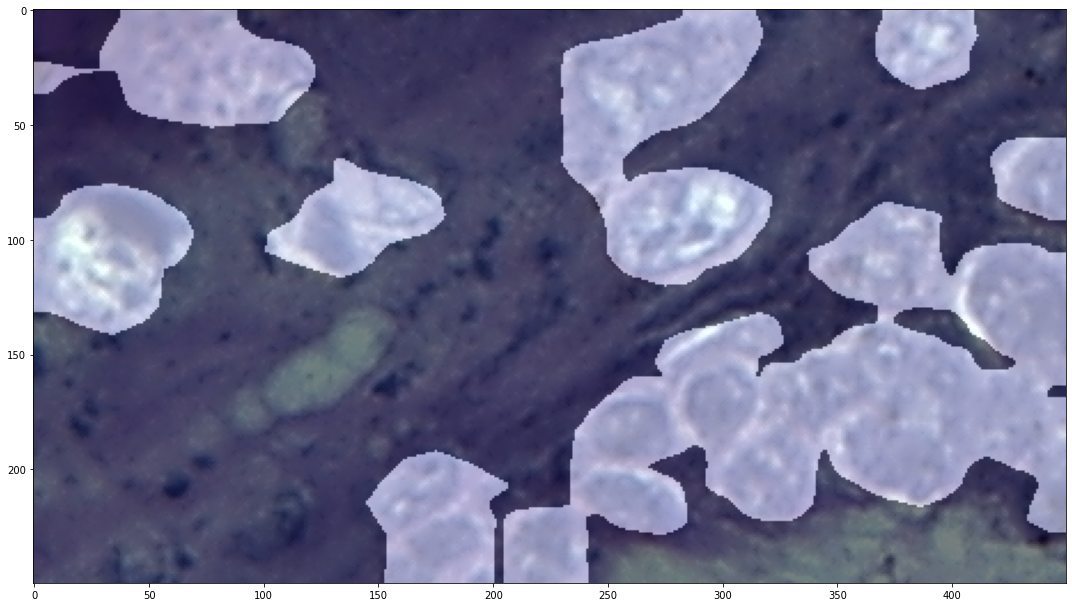

In [17]:
from mmseg.apis import inference_segmentor, show_result_pyplot
img = mmcv.imread('ToTrain/images/image003-2-roi1.tif')

model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, result, palette)

/content/tcc/mmsegmentation/mmseg/models/segmentors/base.py:275: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 576x432 with 0 Axes>

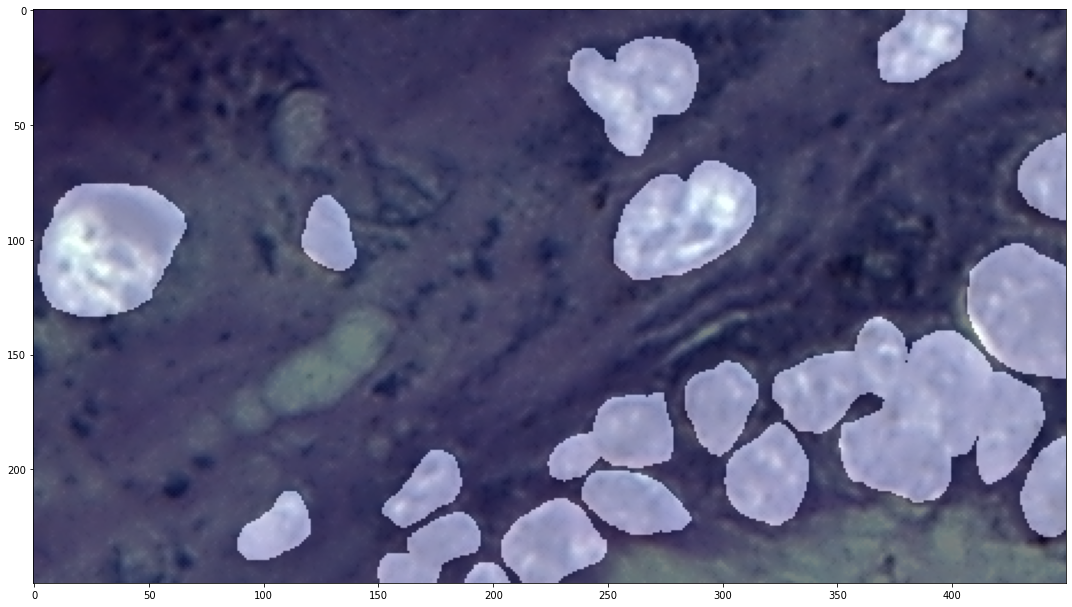

In [18]:
from mmseg.apis import inference_segmentor, show_result_pyplot
img = mmcv.imread('ToTrain/images/image003-2-roi1.tif')
result = mmcv.imread('ToTrain/annotations/image003-2-roi1.tif',flag='grayscale')

model.cfg = cfg
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, [result], palette)

/content/tcc/mmsegmentation/mmseg/models/segmentors/base.py:275: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 576x432 with 0 Axes>

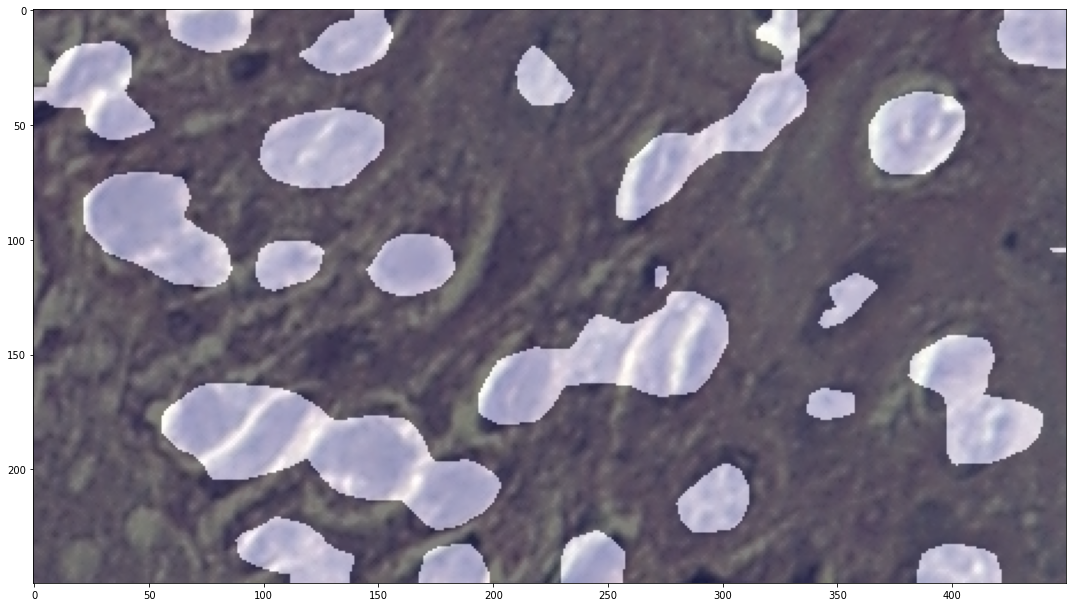

In [19]:
from mmseg.apis import inference_segmentor, show_result_pyplot
img = mmcv.imread('ToTrain/images/image037-roi4.tif')

model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, result, palette)

/content/tcc/mmsegmentation/mmseg/models/segmentors/base.py:275: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 576x432 with 0 Axes>

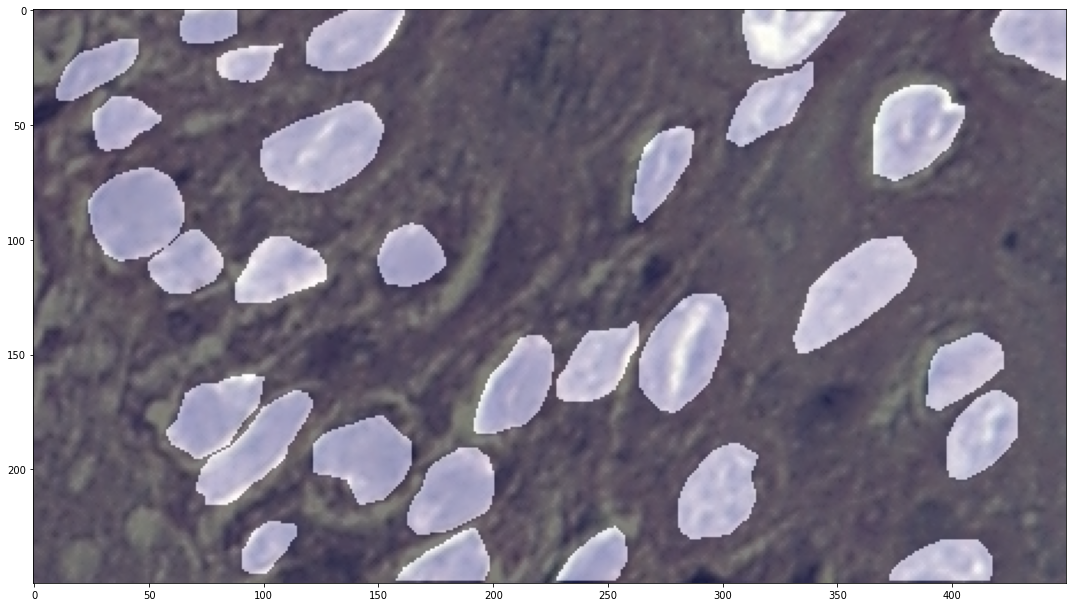

In [20]:
from mmseg.apis import inference_segmentor, show_result_pyplot
img = mmcv.imread('ToTrain/images/image037-roi4.tif')
result = mmcv.imread('ToTrain/annotations/image037-roi4.tif',flag='grayscale')

model.cfg = cfg
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, [result], palette)

In [21]:
!rm -rf segmentation
!unzip ../../segmentation.zip

Archive:  ../../segmentation.zip
   creating: segmentation/
   creating: segmentation/annotations/
   creating: segmentation/annotations/healthy/
  inflating: segmentation/annotations/healthy/image003-2-roi2.tif  
  inflating: segmentation/annotations/healthy/image003-2-roi3.tif  
  inflating: segmentation/annotations/healthy/image003-2-roi4.tif  
  inflating: segmentation/annotations/healthy/image003-2-roi5.tif  
  inflating: segmentation/annotations/healthy/image004-roi1.tif  
  inflating: segmentation/annotations/healthy/image004-roi2.tif  
  inflating: segmentation/annotations/healthy/image004-roi3.tif  
  inflating: segmentation/annotations/healthy/image004-roi4.tif  
  inflating: segmentation/annotations/healthy/image004-roi5.tif  
  inflating: segmentation/annotations/healthy/image005-2-roi1.tif  
  inflating: segmentation/annotations/healthy/image005-2-roi2.tif  
  inflating: segmentation/annotations/healthy/image005-2-roi3.tif  
  inflating: segmentation/annotations/healthy/im

In [24]:
from glob import glob
classes = ['healthy', 'mild', 'moderate', 'severe']
train_images = []
for dysplasia in classes:
    images_glob = glob(f'segmentation/images/{dysplasia}/*')
    for img_path in images_glob:
        img = mmcv.imread(img_path)
        train_images.append((img, f'./work_dirs/psp/raw_res/' + img_path[20:]))

In [39]:
%rm -rf ./work_dirs/psp/raw_res/

In [40]:
%mkdir ./work_dirs/psp/raw_res/
%mkdir ./work_dirs/psp/raw_res/healthy
%mkdir ./work_dirs/psp/raw_res/mild
%mkdir ./work_dirs/psp/raw_res/moderate
%mkdir ./work_dirs/psp/raw_res/severe

In [41]:
import cv2 as cv
opacity = 0.5
fig_size=(15, 10)
for img, path in train_images:
  model.cfg = cfg
  result = inference_segmentor(model, img)
  predict_img = result[0]
  predict_img[predict_img == 1] = 255
  predict_img[predict_img == 0] = 0
  cv.imwrite(f'{path}', predict_img)

./work_dirs/psp/raw_res/healthy/image004-roi2.tif
./work_dirs/psp/raw_res/healthy/image032-roi2.tif
./work_dirs/psp/raw_res/healthy/image005-2-roi3.tif
./work_dirs/psp/raw_res/healthy/image032-roi3.tif
./work_dirs/psp/raw_res/healthy/image029-roi2.tif
./work_dirs/psp/raw_res/healthy/image029-roi3.tif
./work_dirs/psp/raw_res/healthy/image034-roi1.tif
./work_dirs/psp/raw_res/healthy/image034-roi2.tif
./work_dirs/psp/raw_res/healthy/image004-roi5.tif
./work_dirs/psp/raw_res/healthy/image003-2-roi1.tif
./work_dirs/psp/raw_res/healthy/image029-roi1.tif
./work_dirs/psp/raw_res/healthy/image004-roi4.tif
./work_dirs/psp/raw_res/healthy/image032-roi4.tif
./work_dirs/psp/raw_res/healthy/image003-2-roi4.tif
./work_dirs/psp/raw_res/healthy/image033-roi1.tif
./work_dirs/psp/raw_res/healthy/image004-roi1.tif
./work_dirs/psp/raw_res/healthy/image006-2-roi4.tif
./work_dirs/psp/raw_res/healthy/image003-2-roi5.tif
./work_dirs/psp/raw_res/healthy/image029-roi4.tif
./work_dirs/psp/raw_res/healthy/image033

In [31]:
%matplotlib inline
import json

file = open('./work_dirs/psp/None.log.json')
lines = file.readlines()

m_dice = []
m_acc = []
loss = []

for line in lines:
    json_line = json.loads(line)
    if len(json_line):
        if json_line['mode'] == 'train':
            loss.append(json_line['loss'])
        else:
            m_acc.append(json_line['mAcc'])
            m_dice.append(json_line['mDice'])

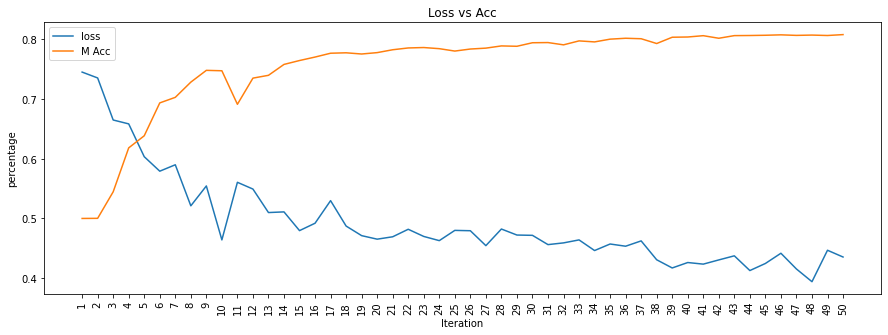

In [32]:
plt.figure(figsize=(15, 5))
plt.plot(range(1, len(m_acc) + 1), loss, label="loss")
plt.plot(range(1, len(m_acc) + 1), m_acc, label="M Acc")
plt.xticks(range(1, len(m_acc) + 1), rotation=90)
plt.title("Loss vs Acc")
plt.xlabel("Iteration")
plt.ylabel("percentage")
plt.legend()
plt.savefig('Loss_vs_Acc_Graph.png')
plt.show()

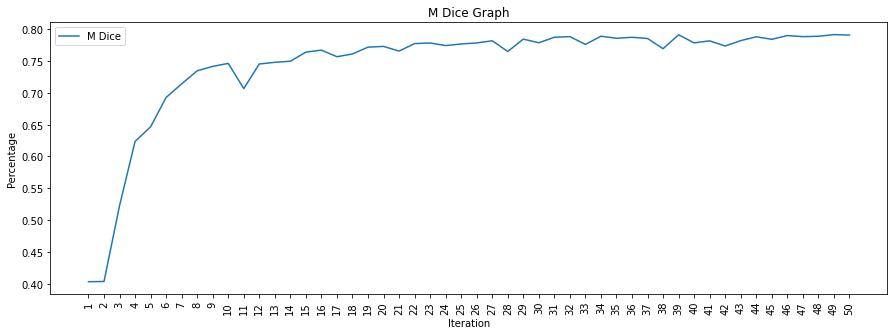

In [33]:
plt.figure(figsize=(15, 5))
plt.plot(range(1, len(m_acc) + 1), m_dice, label="M Dice")
plt.xticks(range(1, len(m_acc) + 1), rotation=90)
plt.title("M Dice Graph")
plt.xlabel("Iteration")
plt.ylabel("Percentage")
plt.legend()
plt.savefig('M_Dice_Graph.png')
plt.show()
plt.close()

In [42]:
!zip -r pspNet_50.zip ./work_dirs/psp/

updating: work_dirs/psp/ (stored 0%)
updating: work_dirs/psp/epoch_10.pth (deflated 8%)
updating: work_dirs/psp/epoch_50.pth (deflated 8%)
updating: work_dirs/psp/epoch_20.pth (deflated 8%)
updating: work_dirs/psp/latest.pth (deflated 8%)
updating: work_dirs/psp/epoch_30.pth (deflated 8%)
updating: work_dirs/psp/None.log.json (deflated 82%)
updating: work_dirs/psp/epoch_40.pth (deflated 8%)
  adding: work_dirs/psp/.ipynb_checkpoints/ (stored 0%)
  adding: work_dirs/psp/raw_res/ (stored 0%)
  adding: work_dirs/psp/raw_res/mild/ (stored 0%)
  adding: work_dirs/psp/raw_res/mild/image018-roi6.tif (deflated 4%)
  adding: work_dirs/psp/raw_res/mild/image018-roi3.tif (deflated 4%)
  adding: work_dirs/psp/raw_res/mild/image006-roi1.tif (deflated 5%)
  adding: work_dirs/psp/raw_res/mild/image008-roi1.tif (deflated 9%)
  adding: work_dirs/psp/raw_res/mild/image021-roi6.tif (deflated 5%)
  adding: work_dirs/psp/raw_res/mild/image008-roi3.tif (deflated 9%)
  adding: work_dirs/psp/raw_res/mild/imag

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [43]:
!cp pspNet_50.zip /content/drive/MyDrive/TCC/